In [8]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [9]:
# Carrega o dataset processado a partir do arquivo Parquet

# --- CORREÇÃO APLICADA AQUI ---
# O '.parent' sobe um nível no diretório (de 'notebooks/' para 'TrustShield/'),
# definindo a raiz do projeto corretamente.
project_root = Path().resolve().parent
# --- FIM DA CORREÇÃO ---

processed_data_path = project_root / "data" / "processed" / "primary_dataset.parquet"
mcc_map_path = project_root / "data" / "raw" / "mcc_codes.json"

df = pd.read_parquet(processed_data_path)

with open(mcc_map_path, "r", encoding="utf-8") as f:
    mcc_map = json.load(f)

print(f"Dataset carregado com {df.shape[0]:,} linhas e {df.shape[1]} colunas.")
df.head()

Dataset carregado com 13,305,915 linhas e 25 colunas.


,id_transaction,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,7,Female,594 Mountain View Street,46.80,-100.76,$23679,$48277,$110153,740,4
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,6,Male,604 Pine Street,40.80,-91.12,$18076,$36853,$112139,834,5
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,4,Male,2379 Forest Lane,33.18,-117.29,$16894,$34449,$36540,686,3
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,5,Female,903 Hill Boulevard,41.42,-87.35,$26168,$53350,$128676,685,5
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,5,Male,166 River Drive,38.86,-76.60,$33529,$68362,$96182,711,2


In [10]:
# --- CÉLULA DE LIMPEZA E PRÉ-PROCESSAMENTO ---

def clean_money(column):
    """Remove o símbolo '$' e converte a coluna para tipo numérico."""
    return pd.to_numeric(column.astype(str).str.replace('$', ''), errors='coerce')

# Lista das colunas monetárias para limpar
money_columns = ['amount', 'per_capita_income', 'yearly_income', 'total_debt']

# Aplica a limpeza
for col in money_columns:
    df[col] = clean_money(df[col])

# Converte a coluna de data para datetime
df['date'] = pd.to_datetime(df['date'])

# Exibe os tipos de dados após a conversão para confirmar a limpeza
print("Tipos de dados após a limpeza:")
df.info(verbose=False, memory_usage='deep')

# Exibe as primeiras linhas do DataFrame limpo
df.head()

Tipos de dados após a limpeza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Columns: 25 entries, id_transaction to num_credit_cards
dtypes: datetime64[ns](1), float64(4), int64(14), object(6)
memory usage: 5.8 GB


,id_transaction,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,7,Female,594 Mountain View Street,46.80,-100.76,23679,48277,110153,740,4
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,6,Male,604 Pine Street,40.80,-91.12,18076,36853,112139,834,5
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,4,Male,2379 Forest Lane,33.18,-117.29,16894,34449,36540,686,3
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,5,Female,903 Hill Boulevard,41.42,-87.35,26168,53350,128676,685,5
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,5,Male,166 River Drive,38.86,-76.60,33529,68362,96182,711,2


In [11]:
# --- CÉLULA DE ENGENHARIA DE FEATURES ---

# 1. Extração de Features Temporais
# Extrai componentes da data, conforme planejado [cite: 38]
df['transaction_hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek # Segunda=0, Domingo=6
df['month'] = df['date'].dt.month

# Cria indicadores para fim de semana e transações noturnas [cite: 39]
df['is_weekend'] = df['day_of_week'].isin([5, 6])
df['is_night_transaction'] = (df['transaction_hour'] <= 6) | (df['transaction_hour'] >= 22)

# 2. Features de Comportamento do Usuário (Exemplo Inicial)
# Conforme o plano, criamos uma razão entre o valor da transação e a média histórica do usuário [cite: 50]
avg_amount_per_user = df.groupby('client_id')['amount'].transform('mean')
df['amount_vs_avg'] = df['amount'] / (avg_amount_per_user + 1) # Adiciona 1 para evitar divisão por zero

print("Novas features criadas com sucesso! ✔️")
df[['date', 'transaction_hour', 'day_of_week', 'is_weekend', 'is_night_transaction', 'amount', 'amount_vs_avg']].head()

Novas features criadas com sucesso! ✔️


,date,transaction_hour,day_of_week,is_weekend,is_night_transaction,amount,amount_vs_avg
0,2010-01-01 00:01:00,0,4,False,True,-77.00,-1.702124
1,2010-01-01 00:02:00,0,4,False,True,14.57,0.523086
2,2010-01-01 00:02:00,0,4,False,True,80.00,1.597729
3,2010-01-01 00:05:00,0,4,False,True,200.00,3.715865
4,2010-01-01 00:06:00,0,4,False,True,46.41,0.645271


In [14]:
# --- CÉLULA DE DIAGNÓSTICO (TEMPORÁRIA) ---
# Carrega os IDs do arquivo de rótulos
fraud_labels_path = project_root / "data" / "raw" / "train_fraud_labels.json"
with open(fraud_labels_path, "r") as f:
    loaded_json = json.load(f)
label_ids = {int(k) for k, v in loaded_json.items() if k.isdigit() and v == 1}

# Pega os IDs do seu DataFrame principal
transaction_ids_in_df = set(df['id_transaction'])

# Verifica a interseção
matching_ids = label_ids.intersection(transaction_ids_in_df)

print(f"Total de rótulos de fraude (label=1) no arquivo JSON: {len(label_ids)}")
print(f"Total de transações no DataFrame: {len(transaction_ids_in_df)}")
print(f"Número de fraudes que correspondem a uma transação no DataFrame: {len(matching_ids)}")

if not matching_ids:
    print("\n🚨 ALERTA: Nenhuma correspondência encontrada. Verifique se os 'id_transaction' são os mesmos nos dois arquivos.")

Total de rótulos de fraude (label=1) no arquivo JSON: 0
Total de transações no DataFrame: 13305915
Número de fraudes que correspondem a uma transação no DataFrame: 0

🚨 ALERTA: Nenhuma correspondência encontrada. Verifique se os 'id_transaction' são os mesmos nos dois arquivos.


In [15]:
# --- CÉLULA PARA DETECÇÃO DE ANOMALIAS COM ISOLATION FOREST ---
from sklearn.ensemble import IsolationForest

print("Pivotando para uma abordagem de Detecção de Anomalias (não supervisionada).\n")

# 1. Preparar os Dados para o Modelo
# A seleção de features continua a mesma
features_to_drop = [
    'id_transaction', 'date', 'client_id', 'card_id',
    'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'address',
    'errors', 'mcc_description', 'is_fraud'
]
# Usamos .copy() para evitar warnings
X = df.drop(columns=features_to_drop, errors='ignore').copy()

# One-Hot Encoding para variáveis categóricas
X = pd.get_dummies(X, columns=['use_chip', 'gender'], drop_first=True, dtype=int)

# 2. Treinar o Modelo Isolation Forest
# 'contamination' é a proporção esperada de anomalias no dataset.
# Vamos começar com um valor baixo, como 0.1%, e ajustar se necessário.
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)

# Treina o modelo com nossos dados
iso_forest.fit(X)

# 3. Identificar as Anomalias (Fraudes em Potencial)
# O modelo retorna -1 para anomalias e 1 para transações normais
predictions = iso_forest.predict(X)
df['anomaly_score'] = predictions

# 4. Analisar os Resultados
print("Análise da Detecção de Anomalias:")
print(df['anomaly_score'].value_counts())

# Exibe algumas das transações que foram sinalizadas como anomalias
print("\nAmostra de transações detectadas como anomalias (potenciais fraudes):")
df[df['anomaly_score'] == -1].head()

Pivotando para uma abordagem de Detecção de Anomalias (não supervisionada).

Análise da Detecção de Anomalias:
anomaly_score
 1    13292609
-1       13306
Name: count, dtype: int64

Amostra de transações detectadas como anomalias (potenciais fraudes):


,id_transaction,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,credit_score,num_credit_cards,transaction_hour,day_of_week,month,is_weekend,is_night_transaction,amount_vs_avg,is_fraud,anomaly_score
3054,7478981,2010-01-01 20:19:00,1168,3239,583.16,Swipe Transaction,34795,Berkeley Heights,NJ,7922.0,...,505,1,20,4,1,False,False,10.977348,0,-1
3474,7479461,2010-01-02 00:17:00,335,5131,332.60,Online Transaction,38958,ONLINE,None,NaN,...,688,3,0,5,1,True,True,5.353593,0,-1
3506,7479495,2010-01-02 01:04:00,989,2511,411.79,Online Transaction,70129,ONLINE,None,NaN,...,727,8,1,5,1,True,True,3.204214,0,-1
3527,7479519,2010-01-02 01:44:00,811,2079,326.69,Swipe Transaction,3558,Great Bend,KS,67530.0,...,741,7,1,5,1,True,True,4.965538,0,-1
3679,7479699,2010-01-02 06:21:00,1692,3646,40.13,Online Transaction,39021,ONLINE,None,NaN,...,542,3,6,5,1,True,True,0.666819,0,-1


Perfil Estatístico Comparativo

--- Transações Anômalas (Potenciais Fraudes) ---
             amount  transaction_hour  credit_score  yearly_income
count  13306.000000      13306.000000  13306.000000   13306.000000
mean     418.729092         11.704419    664.931309  123427.213212
std      466.209441          8.502008     93.566092   65470.416614
min     -500.000000          0.000000    488.000000       2.000000
25%      127.552500          4.000000    584.000000   75711.000000
50%      341.860000         11.000000    675.000000  109673.000000
75%      544.230000         22.000000    728.000000  162709.000000
max     6820.200000         23.000000    850.000000  280199.000000

--- Transações Normais ---
             amount  transaction_hour  credit_score  yearly_income
count  1.329261e+07      1.329261e+07  1.329261e+07   1.329261e+07
mean   4.259991e+01      1.239041e+01  7.139604e+02   4.660687e+04
std    7.946891e+01      5.084154e+00  6.575077e+01   2.424807e+04
min   -5.000000e+02 

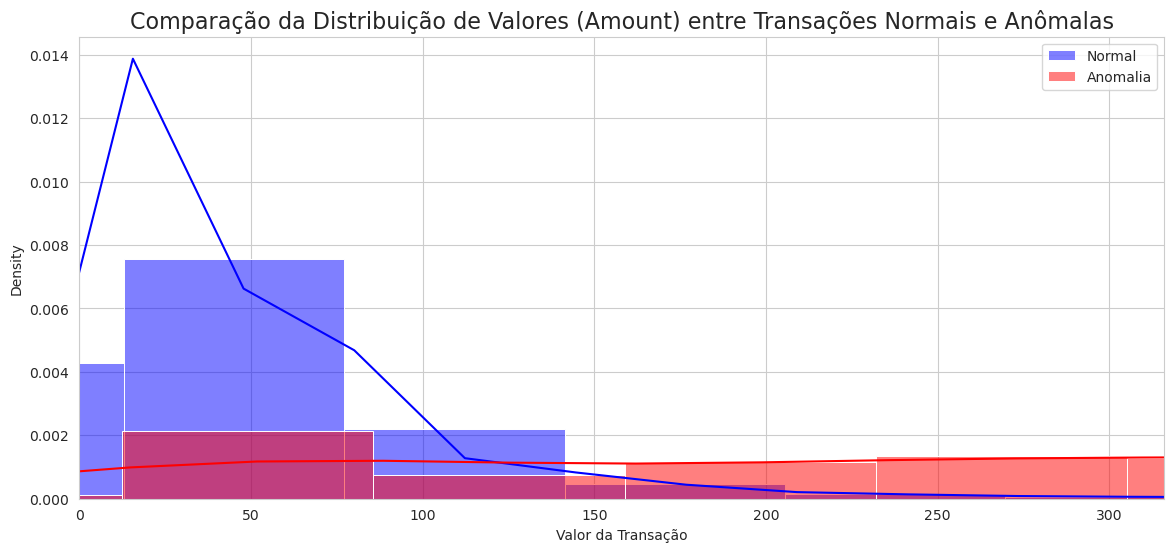

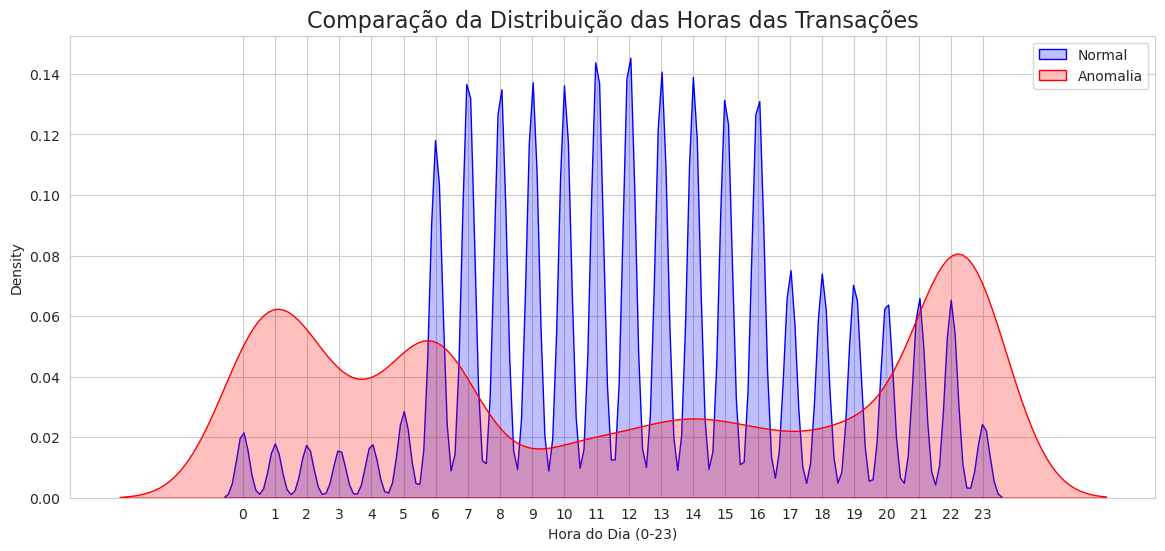

In [16]:
# --- CÉLULA PARA ANÁLISE E INTERPRETAÇÃO DAS ANOMALIAS ---

# 1. Separar as transações normais e anômalas
anomalies = df[df['anomaly_score'] == -1]
normal = df[df['anomaly_score'] == 1]

print("Perfil Estatístico Comparativo\n" + "="*30)
# Compara as estatísticas das colunas numéricas mais importantes
print("\n--- Transações Anômalas (Potenciais Fraudes) ---")
print(anomalies[['amount', 'transaction_hour', 'credit_score', 'yearly_income']].describe())

print("\n--- Transações Normais ---")
print(normal[['amount', 'transaction_hour', 'credit_score', 'yearly_income']].describe())

# 2. Visualizar as Diferenças
# Comparação da distribuição dos valores das transações
plt.figure(figsize=(14, 6))
sns.histplot(normal['amount'], color='blue', label='Normal', kde=True, stat="density", bins=100)
sns.histplot(anomalies['amount'], color='red', label='Anomalia', kde=True, stat="density", bins=100)
plt.title('Comparação da Distribuição de Valores (Amount) entre Transações Normais e Anômalas', fontsize=16)
plt.xlabel('Valor da Transação')
plt.legend()
plt.xlim(0, df['amount'].quantile(0.99)) # Limita o eixo X para melhor visualização
plt.show()

# Comparação das horas das transações
plt.figure(figsize=(14, 6))
sns.kdeplot(normal['transaction_hour'], color='blue', label='Normal', fill=True)
sns.kdeplot(anomalies['transaction_hour'], color='red', label='Anomalia', fill=True)
plt.title('Comparação da Distribuição das Horas das Transações', fontsize=16)
plt.xlabel('Hora do Dia (0-23)')
plt.legend()
plt.xticks(range(0, 24))
plt.show()